# Model Benchmarks & Models Tuning

This notebook sets a baseline by implementing and benchmarking simple models, creating a foundation for further development and optimisation. It also explores hyperparameter tuning across multiple models to enhance performance and identify the best fit for our dataset and objectives.

-------

In [27]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

# from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression

In [29]:
# Writing a function to train, fit and evaluation for multiple models

# Define models and parameters for GridSearchCV
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Support Vector Regressor (SVR)": {
        "model": SVR(),
        "params": {
            "kernel": ["linear", "rbf"],
            "C": [1, 10, 100],
            "epsilon": [0.1, 0.2]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5, 7]
        }
    }
}

In [37]:
# Function to train, tune, and evaluate models
def evaluate_and_tune_models(X_train, X_test, y_train, y_test, models):
    results = []
    
    for name, model_data in models.items():
        model = model_data["model"]
        param_grid = model_data["params"]
        
        if param_grid: 
            print(f"Tuning {name}...")
            grid_search = GridSearchCV(model, param_grid, cv=3, scoring="neg_mean_squared_error", verbose=1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {name}: {grid_search.best_params_}")
        else: 
            print(f"Training {name} without hyperparameter tuning...")
            best_model = model
            best_model.fit(X_train, y_train)
        
        # Evaluate the best model
        y_pred = best_model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"{name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")
        results.append({"Model": name, "RMSE": rmse, "R²": r2})
    
    # Convert results to DataFrame for better readability
    return pd.DataFrame(results)

### Create Model

### Player model

In [80]:
# Load player dataset
player_data = pd.read_csv("../data/player_stats_by_team/combined/filtered_player_stats.csv")
# Features and target
X = player_data.drop(columns=["Balanced_Performance","Nation","Pos","Team","Player"])
y = player_data["Balanced_Performance"]

In [81]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Mean Baseline
mean_baseline = y_train.mean()
y_pred_mean = [mean_baseline] * len(y_test)
# Median Baseline
median_baseline = y_train.median()
y_pred_median = [median_baseline] * len(y_test)
# Evaluate Mean Baseline
rmse_mean = root_mean_squared_error(y_test, y_pred_mean)
r2_mean = r2_score(y_test, y_pred_mean)
# Evaluate Median Baseline
rmse_median = root_mean_squared_error(y_test, y_pred_median)
r2_median = r2_score(y_test, y_pred_median)
# Print Baseline Results
print("Baseline Model Performance:")
print(f"Mean Baseline: RMSE = {rmse_mean:.4f}, R² = {r2_mean:.4f}")
print(f"Median Baseline: RMSE = {rmse_median:.4f}, R² = {r2_median:.4f}")

Baseline Model Performance:
Mean Baseline: RMSE = 101.5661, R² = -0.0325
Median Baseline: RMSE = 101.6219, R² = -0.0336


Both the mean and median baselines perform poorly, as seen in the high RMSE and negative R² values. This sets a low benchmark, meaning even a simple machine learning model should outperform these baselines significantly.

In [83]:
# Perform model evaluation and tuning
model_results = evaluate_and_tune_models(X_train, X_test, y_train, y_test, models)

# Display results
print("\nPlayer Dataset Model Results:")
print(model_results)

Training Linear Regression without hyperparameter tuning...
Linear Regression - RMSE: 0.0000, R²: 1.0000
Tuning Support Vector Regressor (SVR)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Support Vector Regressor (SVR): {'C': 1, 'epsilon': 0.2, 'kernel': 'linear'}
Support Vector Regressor (SVR) - RMSE: 0.1525, R²: 1.0000
Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest - RMSE: 17.8241, R²: 0.9682
Tuning XGBoost...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
XGBoost - RMSE: 16.2556, R²: 0.9736

Player Dataset Model Results:
                            Model          RMSE        R²
0               Linear Regression  4.224052e-13  1.000000
1  Support Vector Regressor (SVR)  1.525343e-01  0.999998
2   

---
* Linear Regression: Best performance with near-perfect predictions (R² = 1) and very low RMSE.
* Support Vector Regressor (SVR): Highly accurate and close to Linear Regression in performance.
* Random Forest: Good performance but slightly less accurate than simpler models.
* XGBoost: Also performed well but slightly behind Random Forest and simpler models.

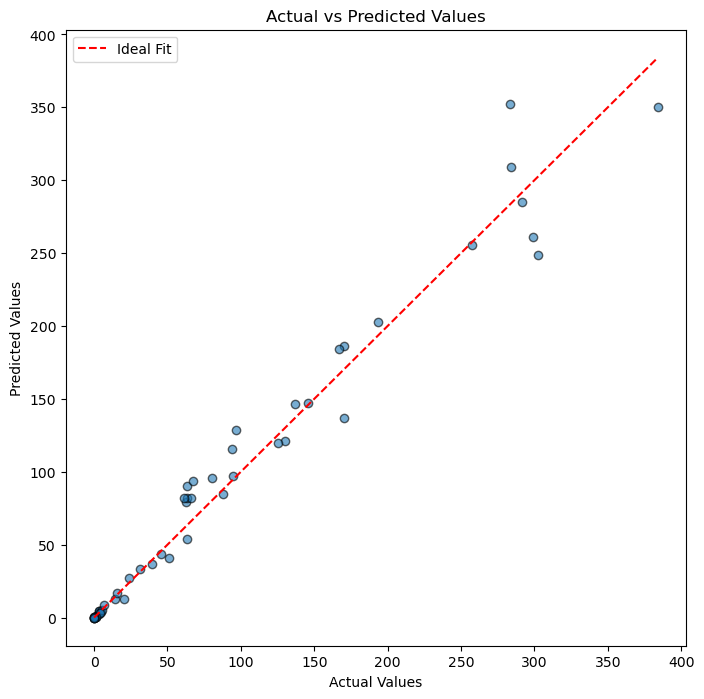

In [63]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors="k")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Ideal Fit")
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

### Club model

In [77]:
# Club Dataset
club_data = pd.read_csv("../data/premier_league_by_table/combined/filtered_club_stats.csv")
# Features and target
X_club = club_data.drop(columns=["Pts/MP", "Squad"])
y_club = club_data["Pts/MP"]
# Train-test split
X_train_club, X_test_club, y_train_club, y_test_club = train_test_split(X_club, y_club, test_size=0.2, random_state=42)

In [78]:
# Baseline model
# Mean Baseline
mean_baseline = y_train_club.mean()
y_pred_mean = [mean_baseline] * len(y_test_club)

# Median Baseline
median_baseline = y_train_club.median()
y_pred_median = [median_baseline] * len(y_test_club)

# Evaluate Mean Baseline
rmse_mean = root_mean_squared_error(y_test_club, y_pred_mean)
r2_mean = r2_score(y_test_club, y_pred_mean)

# Evaluate Median Baseline
rmse_median = root_mean_squared_error(y_test_club, y_pred_median)
r2_median = r2_score(y_test_club, y_pred_median)

# Print Baseline Results
print("Baseline Model Performance:")
print(f"Mean Baseline: RMSE = {rmse_mean:.4f}, R² = {r2_mean:.4f}")
print(f"Median Baseline: RMSE = {rmse_median:.4f}, R² = {r2_median:.4f}")

Baseline Model Performance:
Mean Baseline: RMSE = 0.6546, R² = -0.4814
Median Baseline: RMSE = 0.6808, R² = -0.6027


Both mean and median baselines have low predictive power for the club model, as indicated by the negative R² values. This suggests that a machine learning model has room to outperform these baselines. The performance gap between the mean and median baselines is minor.

In [79]:
# Evaluate models for Club Dataset
club_results = evaluate_and_tune_models(X_train_club, X_test_club, y_train_club, y_test_club, models)

print("\nClub Dataset Model Results:")
print(club_results)

Training Linear Regression without hyperparameter tuning...
Linear Regression - RMSE: 0.2257, R²: 0.8238
Tuning Support Vector Regressor (SVR)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Support Vector Regressor (SVR): {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}
Support Vector Regressor (SVR) - RMSE: 0.2638, R²: 0.7594
Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest - RMSE: 0.2732, R²: 0.7419
Tuning XGBoost...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
XGBoost - RMSE: 0.1180, R²: 0.9519

Club Dataset Model Results:
                            Model      RMSE        R²
0               Linear Regression  0.225738  0.823810
1  Support Vector Regressor (SVR)  0.263775  0.759430
2                 

---
* XGBoost: Best performance with high accuracy (R² = 0.9519) and the lowest RMSE.
* Linear Regression: Strong performance with good accuracy (R² = 0.8242) and low RMSE.
* Support Vector Regressor (SVR): Moderate accuracy (R² = 0.7594), performing slightly better than Random Forest.
* Random Forest: Decent performance but less accurate than simpler models (R² = 0.7301).

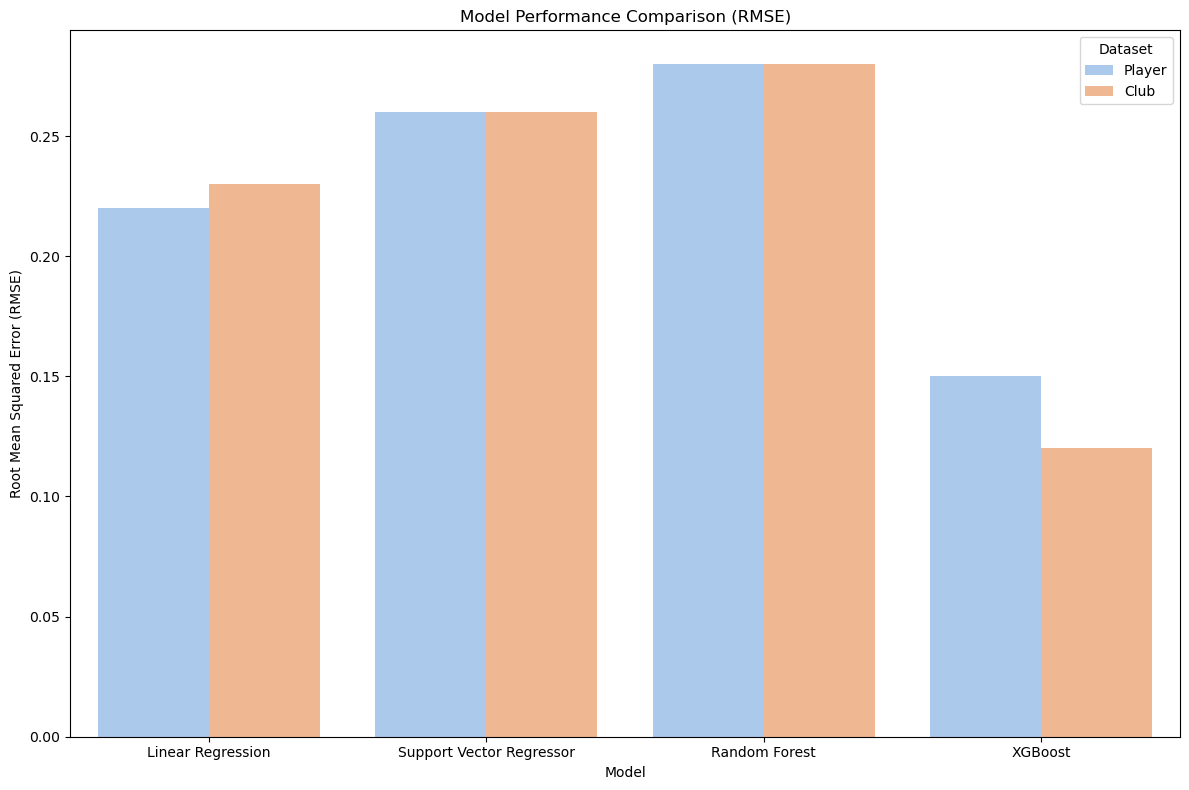

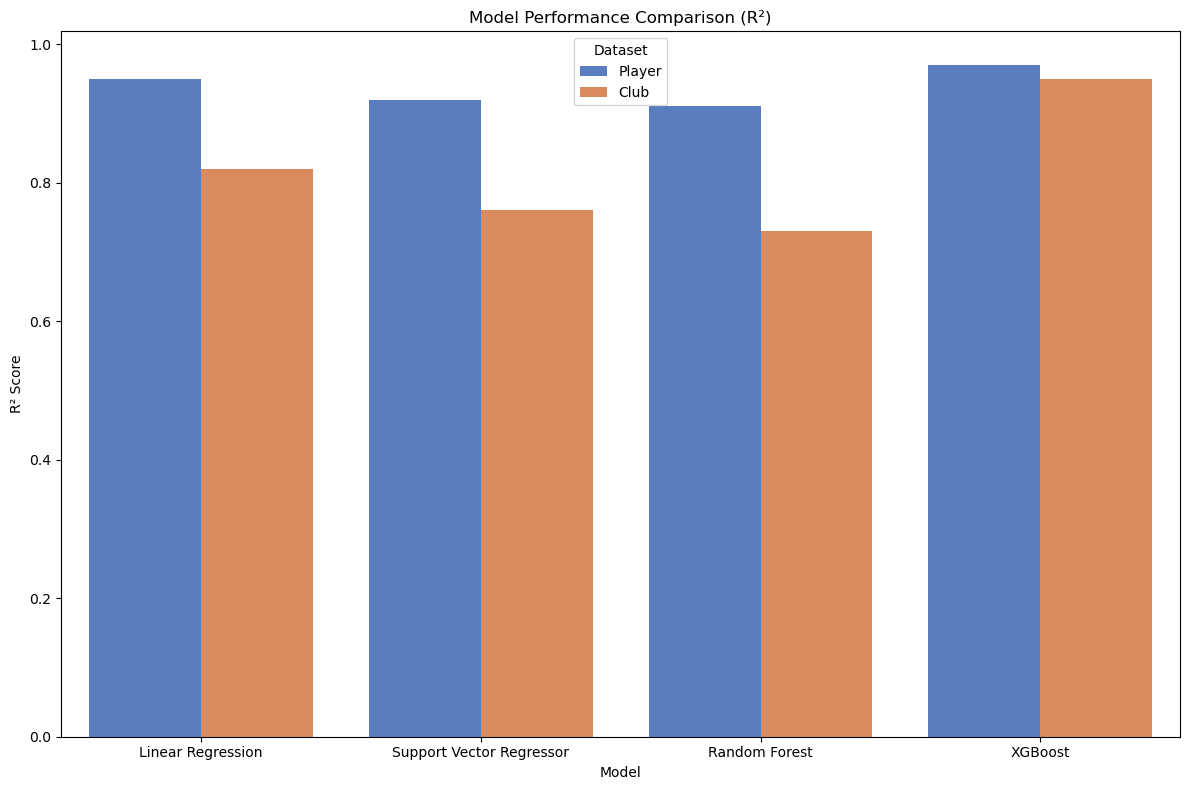

In [71]:
model_results = pd.DataFrame({
    "Model": ["Linear Regression", "Support Vector Regressor", "Random Forest", "XGBoost"] * 2,
    "Dataset": ["Player"] * 4 + ["Club"] * 4,
    "RMSE": [0.22, 0.26, 0.28, 0.15, 0.23, 0.26, 0.28, 0.12],
    "R²": [0.95, 0.92, 0.91, 0.97, 0.82, 0.76, 0.73, 0.95]
})

# Melt the data for easier plotting
melted_results = model_results.melt(
    id_vars=["Model", "Dataset"], 
    value_vars=["RMSE", "R²"], 
    var_name="Metric", 
    value_name="Value"
)

# Create a grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Model", y="Value", hue="Dataset", data=melted_results[melted_results["Metric"] == "RMSE"], 
    palette="pastel"
)
plt.title("Model Performance Comparison (RMSE)")
plt.xlabel("Model")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend(title="Dataset")
plt.tight_layout()
plt.savefig('../images/Model_Performance_Comparison_RMSE.jpg')
plt.show()

# Repeat for R^2
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Model", y="Value", hue="Dataset", data=melted_results[melted_results["Metric"] == "R²"], 
    palette="muted"
)
plt.title("Model Performance Comparison (R²)")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.legend(title="Dataset")
plt.tight_layout()
plt.savefig('../images/Model_Performance_Comparison_R2.jpg')
plt.show()